## **CSI4142 - A3: Part 2**

**Group:** 9

**Members:** 
- Jay Ghosh (300243766) 
- Alexander Azizi-Martin (300236257)

**Introduction**

This notebook presents our solution to Part 2 of Assignment 3, outlining a structured workflow for preparing a dataset for modeling using a decision tree classifier. The process begins data validation, duplicate removal, and exploratory data analysis. Categorical features are one-hot encoded to ensure compatibility with scikit-learn’s decision tree classifier.

Since the dataset is synthetically generated and lacks natural outliers, outliers are manually introduced to analyze their impact on model performance. Additionally, the Local Outlier Factor (LOF) method is applied to detect and handle numeric outliers. Feature engineering is also performed to extract meaningful patterns and enhance predictive power. Finally, multiple dataset variations are tested with the decision tree model, with cross-validation guiding the selection of the optimal dataset for modeling.

In [99]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import inf
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold

#### **Dataset description**

**Dataset name:** Student Performance & Learning Style [1]

**Authors:** Adil Shamim [1]

**Purpose:** This dataset examines the relationship between study habits, learning preferences, and external factors in shaping student performance. It provides insights into how study time, participation, sleep, and technology use influence academic success, supporting research in education and predictive modeling for student outcomes.

**Shape:** 10,000 rows and 15 columns. [1]

In [100]:
# Loading dataset
df_path = kagglehub.dataset_download("adilshamim8/student-performance-and-learning-style")
df = pd.read_csv(f"{df_path}/student_performance_large_dataset.csv")
df.head()

,Student_ID,Age,Gender,Study_Hours_per_Week,Preferred_Learning_Style,Online_Courses_Completed,Participation_in_Discussions,Assignment_Completion_Rate (%),Exam_Score (%),Attendance_Rate (%),Use_of_Educational_Tech,Self_Reported_Stress_Level,Time_Spent_on_Social_Media (hours/week),Sleep_Hours_per_Night,Final_Grade
0,S00001,18,Female,48,Kinesthetic,14,Yes,100,69,66,Yes,High,9,8,C
1,S00002,29,Female,30,Reading/Writing,20,No,71,40,57,Yes,Medium,28,8,D
2,S00003,20,Female,47,Kinesthetic,11,No,60,43,79,Yes,Low,13,7,D
3,S00004,23,Female,13,Auditory,0,Yes,63,70,60,Yes,Low,24,10,B
4,S00005,19,Female,24,Auditory,19,Yes,59,63,93,Yes,Medium,26,8,C


In [101]:
df.shape

(10000, 15)

The dataset contains 5k rows and 15 columns, as is reported by accessing the shape property.

In [102]:
# Running info() to get a basic understanding of the data and the types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   Student_ID                               10000 non-null  object
 1   Age                                      10000 non-null  int64 
 2   Gender                                   10000 non-null  object
 3   Study_Hours_per_Week                     10000 non-null  int64 
 4   Preferred_Learning_Style                 10000 non-null  object
 5   Online_Courses_Completed                 10000 non-null  int64 
 6   Participation_in_Discussions             10000 non-null  object
 7   Assignment_Completion_Rate (%)           10000 non-null  int64 
 8   Exam_Score (%)                           10000 non-null  int64 
 9   Attendance_Rate (%)                      10000 non-null  int64 
 10  Use_of_Educational_Tech                  10000 non-null  ob

The `.info()` method reveals that all columns are complete, with no missing values across all 10000 records. This is further corroborated by the Kaggle page, which also reports 100% completeness [1].

**Feature Details**  

**Student_ID**  
- Type: Numerical  
- Description: Unique identifier assigned to each student.  

**Age**  
- Type: Numerical  
- Description: Student's age at the time of data collection.  
- Range: 18-30 years.  

**Gender**  
- Type: Categorical  
- Description: Student's self-identified gender.  
- Categories: Male, Female, Other.  

**Study_Hours_per_Week**  
- Type: Numerical  
- Description: Total hours a student studies per week.  
- Range: 5-50 hours.  
- Unit: Hours.  

**Preferred_Learning_Style**  
- Type: Categorical  
- Description: Primary learning method preferred by the student.  
- Categories: Visual, Auditory, Reading/Writing, Kinesthetic.  

**Online_Courses_Completed**  
- Type: Numerical  
- Description: Number of online courses the student has completed.  
- Range: 0-20.  

**Participation_in_Discussions**  
- Type: Categorical  
- Description: Whether the student actively participates in academic discussions.  
- Categories: Yes, No.  

**Assignment_Completion_Rate (%)**  
- Type: Numerical  
- Description: Percentage of assignments completed by the student.  
- Range: 50%-100%.  
- Unit: Percentage.  

**Exam_Score (%)**  
- Type: Numerical  
- Description: Student's final exam score.  
- Range: 40%-100%.  
- Unit: Percentage.  

**Attendance_Rate (%)**  
- Type: Numerical  
- Description: Percentage of classes attended by the student.  
- Range: 50%-100%.  
- Unit: Percentage.  

**Use_of_Educational_Tech**  
- Type: Categorical  
- Description: Whether the student uses educational technology tools.  
- Categories: Yes, No.  

**Self_Reported_Stress_Level**  
- Type: Categorical  
- Description: Student's self-reported level of academic stress.  
- Categories: Low, Medium, High.  

**Time_Spent_on_Social_Media (hours/week)**  
- Type: Numerical  
- Description: Average number of hours per week spent on social media.  
- Range: 0-30 hours.  
- Unit: Hours.  

**Sleep_Hours_per_Night**  
- Type: Numerical  
- Description: Average hours of sleep per night.  
- Range: 4-10 hours.  
- Unit: Hours.  

**Final_Grade**  
- Type: Categorical  
- Description: Assigned final grade based on exam performance.  
- Categories: A, B, C, D, F.

### **Section A: Validating and Cleaning**

#### **Check 1: Data Type**

In [103]:
# Define columns with explicitly expected datatypes
expected_dtypes = {
  'Student_ID': 'string',
  'Age': 'numeric',
  'Gender': 'string',
  'Study_Hours_per_Week': 'numeric',
  'Preferred_Learning_Style': 'string',
  'Online_Courses_Completed': 'numeric',
  'Participation_in_Discussions': 'string',
  'Assignment_Completion_Rate (%)': 'numeric',
  'Exam_Score (%)': 'numeric',
  'Attendance_Rate (%)': 'numeric',
  'Use_of_Educational_Tech': 'string',
  'Self_Reported_Stress_Level': 'string',
  'Time_Spent_on_Social_Media (hours/week)': 'numeric',
  'Sleep_Hours_per_Night': 'numeric',
  'Final_Grade': 'string'
}

# Checker Code
errors = {}
for col, expected_type in expected_dtypes.items():
  if expected_type == "numeric":
    parsed_col = pd.to_numeric(df[col], errors="coerce")
    failed_mask = parsed_col.isna() & df[col].notna()
  elif expected_type == "string":
    failed_mask = ~df[col].apply(lambda x: isinstance(x, str))
  errors[col] = df.loc[failed_mask]
  
# Results
for col, errors_df in errors.items():
  type_to_check = expected_dtypes[col]
  print(f"Report on Data Type Check for '{col}' ({type_to_check})")
  if errors_df.empty:
    print(f"No data type errors found in column '{col}'.")
  else:
    print(f"{len(errors_df)} rows have invalid {type_to_check} values in '{col}'.")
    print("Examples of invalid rows:")
    display(errors_df.head(10))

Report on Data Type Check for 'Student_ID' (string)
No data type errors found in column 'Student_ID'.
Report on Data Type Check for 'Age' (numeric)
No data type errors found in column 'Age'.
Report on Data Type Check for 'Gender' (string)
No data type errors found in column 'Gender'.
Report on Data Type Check for 'Study_Hours_per_Week' (numeric)
No data type errors found in column 'Study_Hours_per_Week'.
Report on Data Type Check for 'Preferred_Learning_Style' (string)
No data type errors found in column 'Preferred_Learning_Style'.
Report on Data Type Check for 'Online_Courses_Completed' (numeric)
No data type errors found in column 'Online_Courses_Completed'.
Report on Data Type Check for 'Participation_in_Discussions' (string)
No data type errors found in column 'Participation_in_Discussions'.
Report on Data Type Check for 'Assignment_Completion_Rate (%)' (numeric)
No data type errors found in column 'Assignment_Completion_Rate (%)'.
Report on Data Type Check for 'Exam_Score (%)' (nu

No data type errors, so no cleaning required here.

#### **Check 2: Range Check**

In [104]:
# Define ranges for numeric columns
ranges = {
    "Sleep_Hours_per_Night": (1, 16),
    "Attendance_Rate (%)": (0, 100),
    "Exam_Score (%)": (0, 100),
    "Assignment_Completion_Rate (%)": (0, 100),
    "Online_Courses_Completed": (0, inf),
    "Study_Hours_per_Week": (0, 24 * 7),
    "Age": (0, 40),
}

# Checker Code
range_errors = {}
for col, (min_val, max_val) in ranges.items():
    out_of_range_mask = (df[col] < min_val) | (df[col] > max_val)
    range_errors[col] = df.loc[out_of_range_mask]

# Results
for col, error_df in range_errors.items():
    print(f"Report on Range Check for '{col}' (Range: {ranges[col]})")
    if error_df.empty:
        print(f"No range errors found in column '{col}'.")
    else:
        print(f"{len(error_df)} range errors found in column '{col}'.")
        print("Examples of out-of-range rows:")
        display(error_df.head(10))

Report on Range Check for 'Sleep_Hours_per_Night' (Range: (1, 16))
No range errors found in column 'Sleep_Hours_per_Night'.
Report on Range Check for 'Attendance_Rate (%)' (Range: (0, 100))
No range errors found in column 'Attendance_Rate (%)'.
Report on Range Check for 'Exam_Score (%)' (Range: (0, 100))
No range errors found in column 'Exam_Score (%)'.
Report on Range Check for 'Assignment_Completion_Rate (%)' (Range: (0, 100))
No range errors found in column 'Assignment_Completion_Rate (%)'.
Report on Range Check for 'Online_Courses_Completed' (Range: (0, inf))
No range errors found in column 'Online_Courses_Completed'.
Report on Range Check for 'Study_Hours_per_Week' (Range: (0, 168))
No range errors found in column 'Study_Hours_per_Week'.
Report on Range Check for 'Age' (Range: (0, 40))
No range errors found in column 'Age'.


No range errors, so no cleaning required here.

#### **Check 3: Format Check**

In [105]:
# Define format rules as regex patterns for relevant columns
format_rules = {
    "Student_ID": r"^S\d{5}$",  # S followed by 5 digits
}

# Checker Code
format_errors = {}
for col, pattern in format_rules.items():
    failed_mask = ~df[col].astype(str).str.match(pattern)
    format_errors[col] = df.loc[failed_mask]

# Results
for col, error_df in format_errors.items():
    print(f"Report on Format Check for '{col}' (Pattern: '{format_rules[col]}')")
    if error_df.empty:
        print(f"No format errors found in column '{col}'.")
    else:
        print(f"{len(error_df)} format errors found in column '{col}'.")
        print("Examples of format errors:")
        display(error_df.head(10))

Report on Format Check for 'Student_ID' (Pattern: '^S\d{5}$')
No format errors found in column 'Student_ID'.


No format errors, so no cleaning required here.

#### **Check 4: Consistency Check**

The only necessary consistency check is ensuring that the Final_Grade matches the Exam_Score (%) based on the grading criteria: D for scores between 40% and 54.99%, C for 55% to 69.99%, B for 70% to 84.99%, and A for 85% to 100%.

In [106]:
# Define the column for consistency check
consistency_col = "Exam_Score (%)"
grade_col = "Final_Grade"

# Checker Code
consistency_errors = {}
for index, row in df.iterrows():
    exam_score = row[consistency_col]
    final_grade = row[grade_col]
    
    # Define the grading criteria
    if (40 <= exam_score < 55 and final_grade != "D") or \
       (55 <= exam_score < 70 and final_grade != "C") or \
       (70 <= exam_score < 85 and final_grade != "B") or \
       (85 <= exam_score <= 100 and final_grade != "A"):
        consistency_errors[index] = row

# Results
if consistency_errors:
    print(f"Report on Consistency Check between '{consistency_col}' and '{grade_col}'")
    print(f"{len(consistency_errors)} rows have inconsistent final grades based on exam scores.")
    print("Examples of inconsistent rows:")
    display(pd.DataFrame(consistency_errors).head(10))
else:
    print("No consistency issues found between exam scores and final grades.")

No consistency issues found between exam scores and final grades.


No consistency check errors, so no cleaning required here.

#### **Check 5: Uniqueness Check** 


In [107]:
# Define which columns must be unique for uniqueness checks
unique_cols = [
    "Student_ID",
]

# Checker Code
unique_errors = {}
for col in unique_cols:
    duplicate_mask = df.duplicated(subset=[col], keep=False)
    unique_errors[col] = df.loc[duplicate_mask]

# Results
for col, error_df in unique_errors.items():
    print(f"Report on Uniqueness Check for '{col}'")
    if error_df.empty:
        print("No duplicates found.")
    else:
        print(f"{len(error_df)} rows contain duplicate values in '{col}'.")
        print("Examples of duplicated rows:")
        display(error_df.head(10))

Report on Uniqueness Check for 'Student_ID'
No duplicates found.


No uniqueness check errors, so no cleaning required here.

#### **Check 6: Presence Check** 

In [108]:
# Define which columns must not be null for presence checks
presence_cols = [
    "Student_ID",
    "Age",
    "Gender",
    "Final_Grade"
]

# Checker Code
presence_errors = {}
for col in presence_cols:
    missing_mask = df[col].isnull()
    presence_errors[col] = df.loc[missing_mask]

# Results
for col, error_df in presence_errors.items():
    print(f"Report on Presence Check for '{col}'")
    if error_df.empty:
        print(f"No missing values found in column '{col}'.")
    else:
        print(f"{len(error_df)} rows have missing (null) values in '{col}'.")
        print("Examples of missing-value rows:")
        display(error_df.head(10))

Report on Presence Check for 'Student_ID'
No missing values found in column 'Student_ID'.
Report on Presence Check for 'Age'
No missing values found in column 'Age'.
Report on Presence Check for 'Gender'
No missing values found in column 'Gender'.
Report on Presence Check for 'Final_Grade'
No missing values found in column 'Final_Grade'.


No presence check errors, so no cleaning required here.

#### **Check 7: Length Check** 

In [109]:
# Define the minimum and maximum allowed lengths for each string column
# Format: { column_name: (min_length, max_length) }
length_constraints = {
    "Student_ID": (6, 6),
}

# Checker Code
length_errors = {}
for col, (min_len, max_len) in length_constraints.items():
    str_col = df[col].astype(str)
    # Identify rows that are too short or too long
    too_short_mask = str_col.str.len() < min_len
    too_long_mask = str_col.str.len() > max_len
    # Combine both to create the final mask
    length_mask = too_short_mask | too_long_mask
    length_errors[col] = df.loc[length_mask]

# Results
for col, error_df in length_errors.items():
    print(f"Report on Length Check for '{col}' (Allowed: {length_constraints[col]})")
    if error_df.empty:
        print(f"No length errors found in column '{col}'.")
    else:
        print(f"{len(error_df)} rows have length errors in '{col}'.")
        print("Examples of invalid length rows:")
        display(error_df.head(10))

Report on Length Check for 'Student_ID' (Allowed: (6, 6))
No length errors found in column 'Student_ID'.


No length errors, so no cleaning required here.

#### **Check 8: Lookup Check** 

In [110]:
# Define valid values for each categorical column
lookup_valid_values = {
  "Self_Reported_Stress_Level": ['Low', 'Medium', 'High'],
  "Preferred_Learning_Style": ['Kinesthetic', 'Reading/Writing', 'Auditory', 'Visual'],
  "Gender": ["Female", "Male", "Other"],
  "Use_of_Educational_Tech": ["Yes", 'No'],
  "Participation_in_Discussions": ["Yes", "No"],
  "Final_Grade": ["A", "B", "C", "D"]
}

# Checker Code
lookup_errors = {}
for col, valid_list in lookup_valid_values.items():
  invalid_mask = ~df[col].isin(valid_list)
  lookup_errors[col] = df.loc[invalid_mask]

# Results
for col, error_df in lookup_errors.items():
  print(f"Report on Look-up Check for '{col}' (Valid Values: {lookup_valid_values[col]})")
  if error_df.empty:
    print(f"No invalid categories found in column '{col}'.")
  else:
    print(f"{len(error_df)} rows have invalid categories in '{col}'.")
    print("Examples of invalid-category rows:")
    display(error_df.head(10))

Report on Look-up Check for 'Self_Reported_Stress_Level' (Valid Values: ['Low', 'Medium', 'High'])
No invalid categories found in column 'Self_Reported_Stress_Level'.
Report on Look-up Check for 'Preferred_Learning_Style' (Valid Values: ['Kinesthetic', 'Reading/Writing', 'Auditory', 'Visual'])
No invalid categories found in column 'Preferred_Learning_Style'.
Report on Look-up Check for 'Gender' (Valid Values: ['Female', 'Male', 'Other'])
No invalid categories found in column 'Gender'.
Report on Look-up Check for 'Use_of_Educational_Tech' (Valid Values: ['Yes', 'No'])
No invalid categories found in column 'Use_of_Educational_Tech'.
Report on Look-up Check for 'Participation_in_Discussions' (Valid Values: ['Yes', 'No'])
No invalid categories found in column 'Participation_in_Discussions'.
Report on Look-up Check for 'Final_Grade' (Valid Values: ['A', 'B', 'C', 'D'])
No invalid categories found in column 'Final_Grade'.


No lookup check errors, so no cleaning required here.

#### **Check 9: Duplicate Check** 

In [111]:
# Checker Code
duplicate_errors = df[df.duplicated(keep='first')]

# Results
if duplicate_errors.empty:
    print("No exact duplicate errors found.")
else:
    print(f"{len(duplicate_errors)} rows are involved in exact duplicates.")
    print("Examples of duplicate rows:")
    display(duplicate_errors.head(10))

No exact duplicate errors found.


No exact duplicate errors, so no cleaning required here.

#### **Check 10: Near Duplicate Errors** 

This dataset contains limited identifiable information for students, specifically age, gender, and student ID. The student ID has already been verified as unique in the previous uniqueness check. With a relatively large dataset of 10,000 samples, it's likely that other features could be similar across students. Given that there are no missing values and the chance of students having similar results is high, it is unnecessary to check for or address near duplicates within this dataset, as the likelihood of overlap is significant.

### **Section B: One-Hot Encoding**

Scikit DecisionTreeClassifier requires all feature columns be numerical, as a result, below we use one hot encoding to encode the categorical feature columns as numerical feature columns. Additionally, columns containing "Yes" or "No" values are encoded as 1 or 0, respectively.

In [112]:
# Define our categorical columns
categorical_cols = ["Gender", "Preferred_Learning_Style", "Self_Reported_Stress_Level"]
# One-hot encode but also keep original columns 
# This is for categorical outlier analysis
categorical_df = []
for col in categorical_cols:
    encoder = OneHotEncoder(sparse_output=False)
    df_col = pd.DataFrame(
        encoder.fit_transform(df[[col]]),
        columns=encoder.get_feature_names_out([col])
    )
    categorical_df.append(df_col)

df_encoded = pd.concat([
    *categorical_df,
    df
], axis=1)

# Encodes "Yes" or "No" categorical features as 1 or 0 respectively
df_encoded["Participation_in_Discussions"] = (df["Participation_in_Discussions"] == "Yes").apply(int)
df_encoded["Use_of_Educational_Tech"] = (df["Use_of_Educational_Tech"] == "Yes").apply(int)

# Displaying the transformed dataset
print("Original shape:", df.shape)
print("Encoded shape:", df_encoded.shape)
print("One-hot encoded dataset (head):")
df_encoded.head()

Original shape: (10000, 15)
Encoded shape: (10000, 25)
One-hot encoded dataset (head):


,Gender_Female,Gender_Male,Gender_Other,Preferred_Learning_Style_Auditory,Preferred_Learning_Style_Kinesthetic,Preferred_Learning_Style_Reading/Writing,Preferred_Learning_Style_Visual,Self_Reported_Stress_Level_High,Self_Reported_Stress_Level_Low,Self_Reported_Stress_Level_Medium,...,Online_Courses_Completed,Participation_in_Discussions,Assignment_Completion_Rate (%),Exam_Score (%),Attendance_Rate (%),Use_of_Educational_Tech,Self_Reported_Stress_Level,Time_Spent_on_Social_Media (hours/week),Sleep_Hours_per_Night,Final_Grade
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,14,1,100,69,66,1,High,9,8,C
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,20,0,71,40,57,1,Medium,28,8,D
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,11,0,60,43,79,1,Low,13,7,D
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,1,63,70,60,1,Low,24,10,B
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,19,1,59,63,93,1,Medium,26,8,C


**Removing "Student_ID" and "Exam_Score" column**

We drop the "Student_ID", because doesn’t directly contribute numerical or categorical information that a decision tree classifier model can leverage. Additionally, the "Exam_Score" column is dropped because the "Final_Grade" target column is determined by the value of the "Exam_Score". This relationship is based on the marking scheme discussed above within the "Consistency Check" section. Keeping this column will result in the classification model exploiting this relationship to predict students grades, which is why it needs to be dropped. 

In [113]:
df = df_encoded.drop(columns=["Student_ID", "Exam_Score (%)"])
# Show new dataframe without name column
display(df.head())

,Gender_Female,Gender_Male,Gender_Other,Preferred_Learning_Style_Auditory,Preferred_Learning_Style_Kinesthetic,Preferred_Learning_Style_Reading/Writing,Preferred_Learning_Style_Visual,Self_Reported_Stress_Level_High,Self_Reported_Stress_Level_Low,Self_Reported_Stress_Level_Medium,...,Preferred_Learning_Style,Online_Courses_Completed,Participation_in_Discussions,Assignment_Completion_Rate (%),Attendance_Rate (%),Use_of_Educational_Tech,Self_Reported_Stress_Level,Time_Spent_on_Social_Media (hours/week),Sleep_Hours_per_Night,Final_Grade
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,Kinesthetic,14,1,100,66,1,High,9,8,C
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,Reading/Writing,20,0,71,57,1,Medium,28,8,D
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,Kinesthetic,11,0,60,79,1,Low,13,7,D
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,Auditory,0,1,63,60,1,Low,24,10,B
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,Auditory,19,1,59,93,1,Medium,26,8,C


### **Section C: Outliers and LOF**

**Creating DR & DT**

In [114]:
# Splitting the total dataset
# Taking 80% for DR, 20% for DT
DR, DT = train_test_split(df, test_size=0.2, random_state=42)
print("DR shape:", DR.shape)
print("DT shape:", DT.shape)

DR shape: (8000, 23)
DT shape: (2000, 23)


**Finding features for LOF**

First, we display the distributions of relevant, numerical features for LOF with possible outliers.

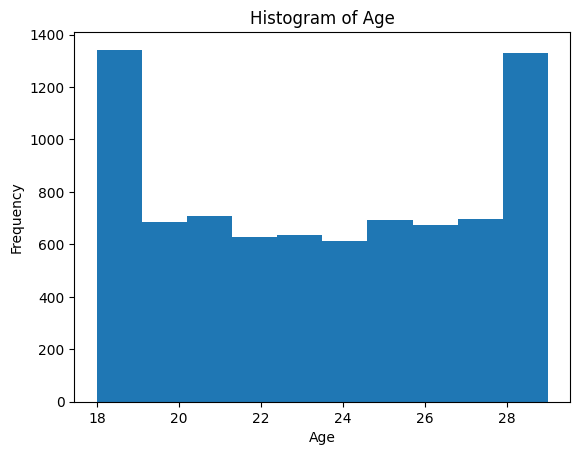

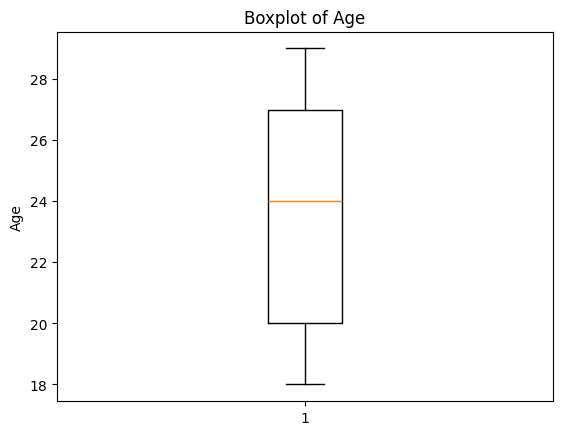

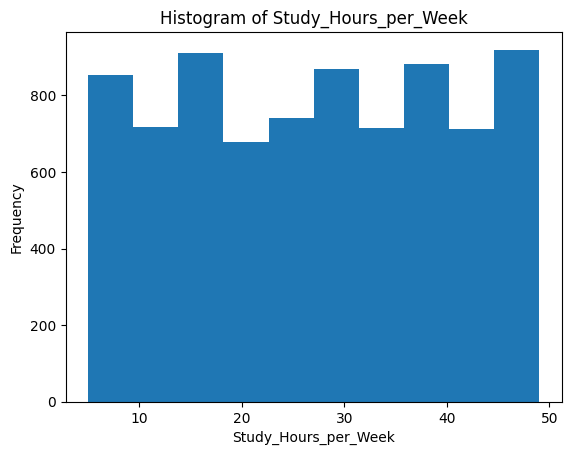

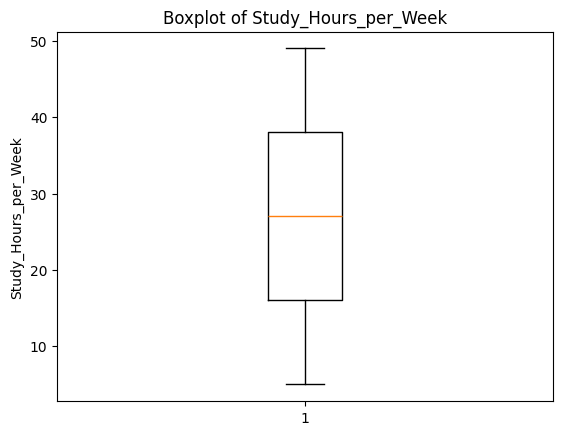

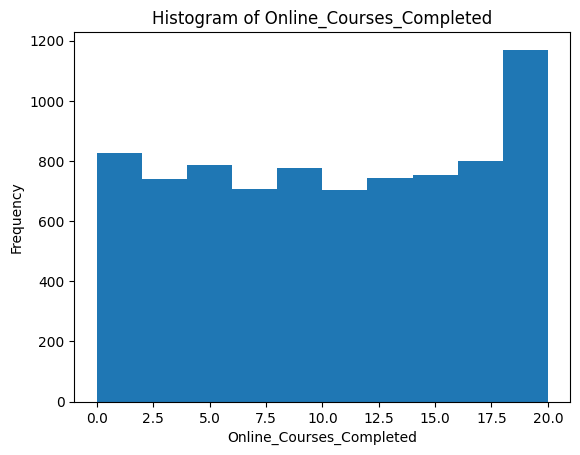

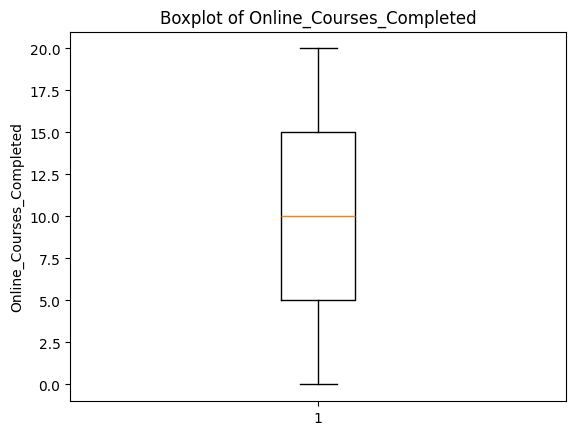

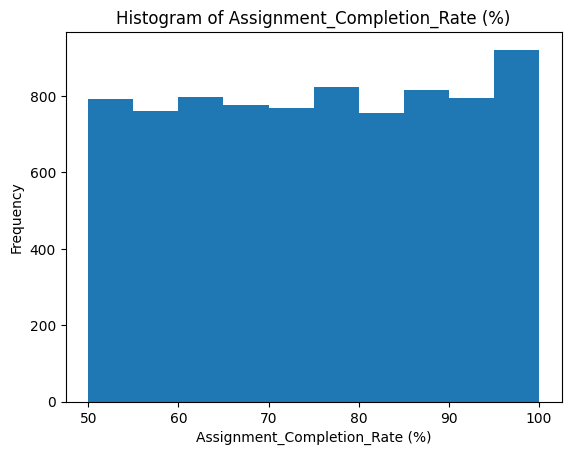

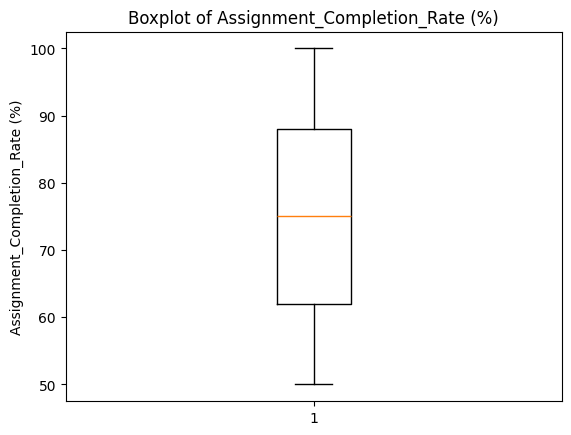

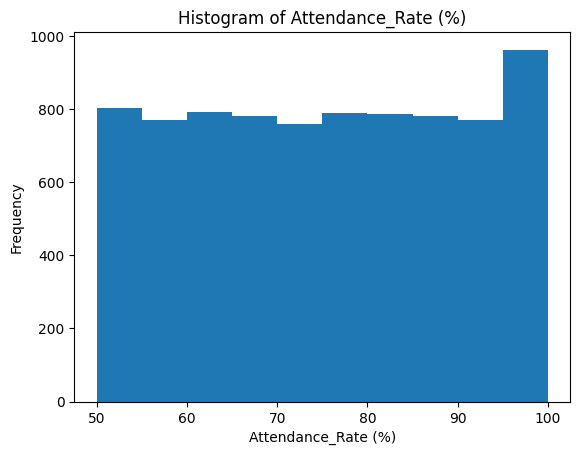

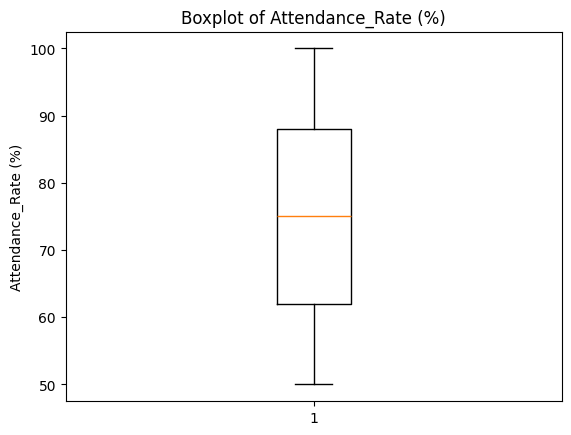

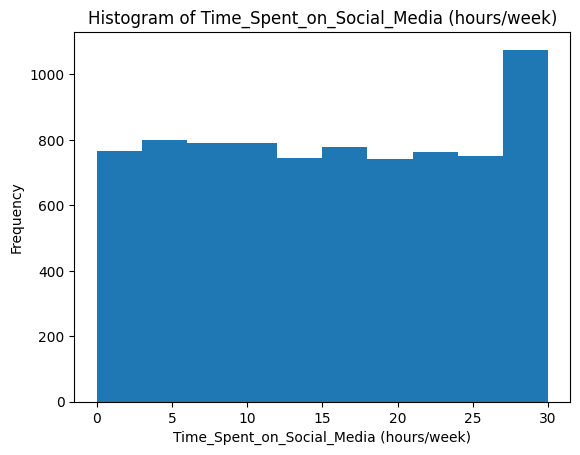

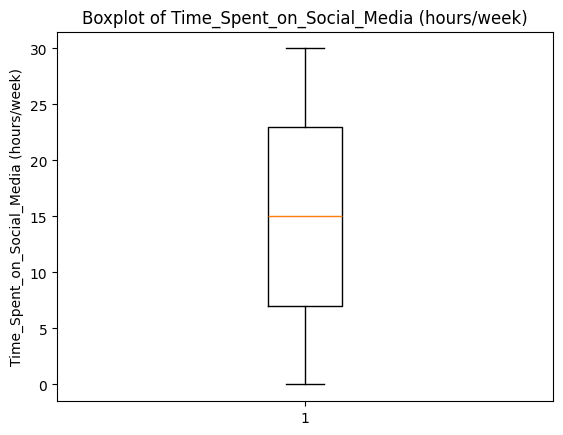

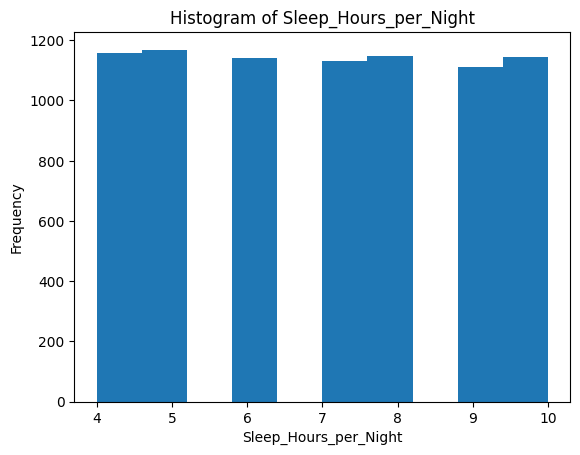

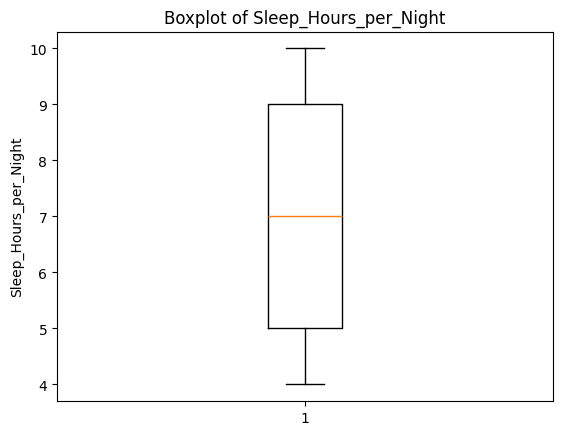

In [115]:
# Numeric columns relevant to outlier detection and LOF usage
numeric_cols = ["Age", "Study_Hours_per_Week", "Online_Courses_Completed", "Assignment_Completion_Rate (%)", "Attendance_Rate (%)", "Time_Spent_on_Social_Media (hours/week)", "Sleep_Hours_per_Night"]
# Display distribution for each numeric column
for col in numeric_cols:
    plt.figure()
    plt.hist(DR[col].dropna())
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()
    plt.figure()
    plt.boxplot(DR[col].dropna())
    plt.title(f"Boxplot of {col}")
    plt.ylabel(col)
    plt.show()

As seen in the histogram charts above, all features are approximately uniformly distributed, except for age, which exhibits a bimodal distribution. The most common ages are 18 and 30, with a dip between them. Additionally, no data points within the boxplot charts fall outside the range defined by [Q1 - 1.5 * IQR, Q3 + 1.5 * IQR], indicating that there are no outliers in this dataset.

Upon reviewing the Kaggle page, it is noted that the data is synthetically generated, which aligns with these observations. To introduce outliers, entries in the "Assignment_Completion_Rate (%)" and "Attendance_Rate (%)" columns will be randomly replaced with a 0.1% probability with the following equation: *mean - (4 * std) + noise*. The noise is a small random value sampled from a normal distribution with a mean of 0 and a standard deviation of 0.1 * std.

In [116]:
for col in ["Assignment_Completion_Rate (%)", "Attendance_Rate (%)"]:
    mean = DR[col].mean()
    std = DR[col].std()

    mask = np.random.rand(len(DR)) < 0.001
    noise = np.random.normal(0, 0.1 * std, size=mask.sum())

    DR.loc[mask, col] = (mean - (4 * std) + noise).astype(int)

Displaying the charts again will reveal the updated distributions following the introduction of the outliers.

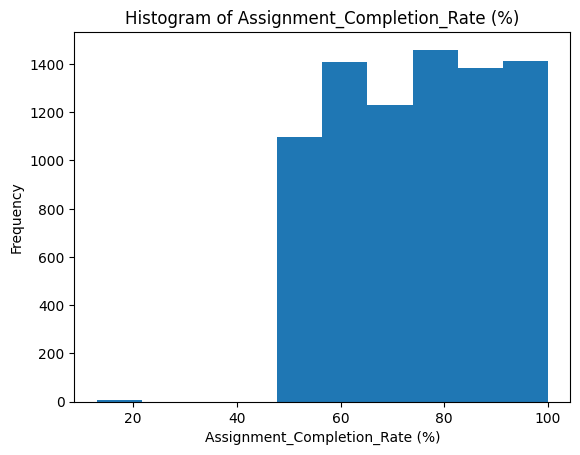

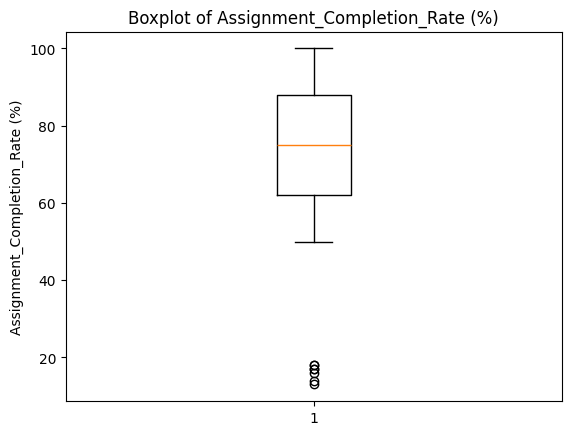

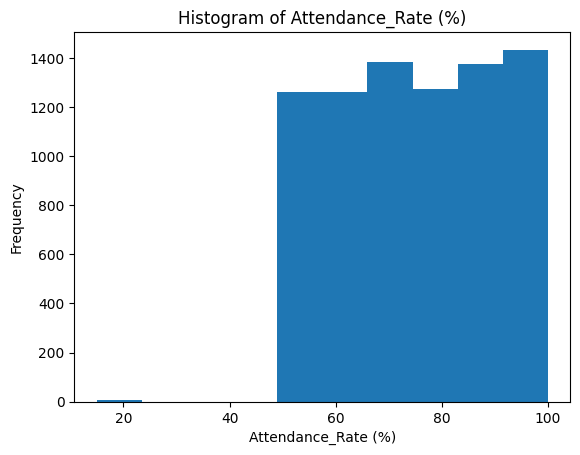

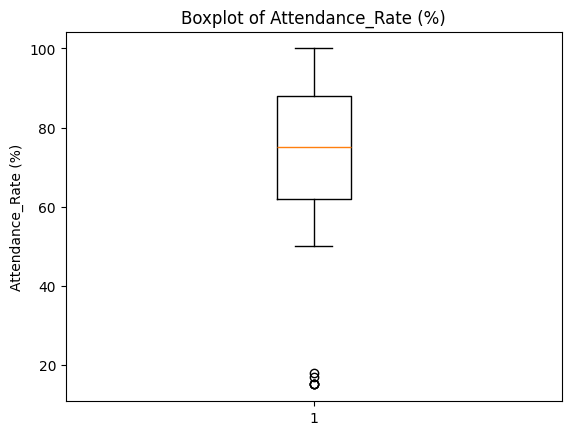

In [117]:
# Display distribution for each "Assignment_Completion_Rate (%)" and "Attendance_Rate (%)" columns
for col in ["Assignment_Completion_Rate (%)", "Attendance_Rate (%)"]:
    plt.figure()
    plt.hist(DR[col].dropna())
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()
    plt.figure()
    plt.boxplot(DR[col].dropna())
    plt.title(f"Boxplot of {col}")
    plt.ylabel(col)
    plt.show()

As observed in the charts above, the box plot contain outlier points, while the histograms reveal a concentration of values in the center, with outliers present at the left ends of the distribution.

Even though LOF doesn't operate on categorical features, we display their counts to see if there's any feature with extremely low count or not.

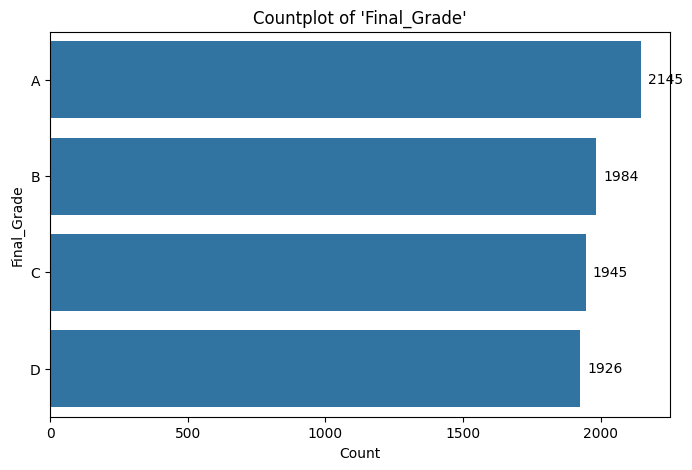

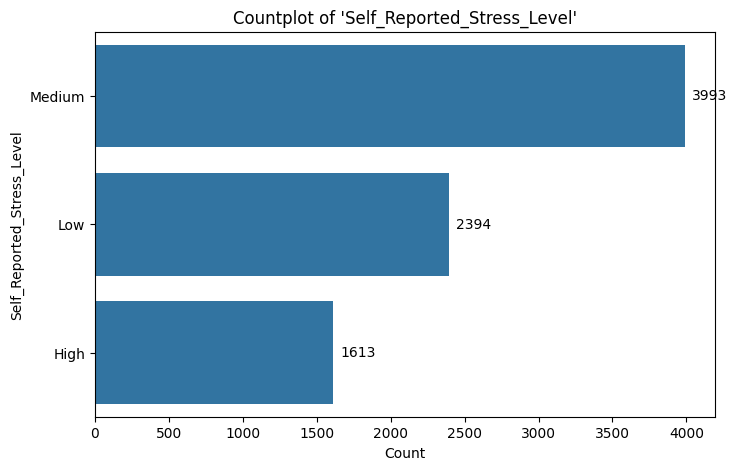

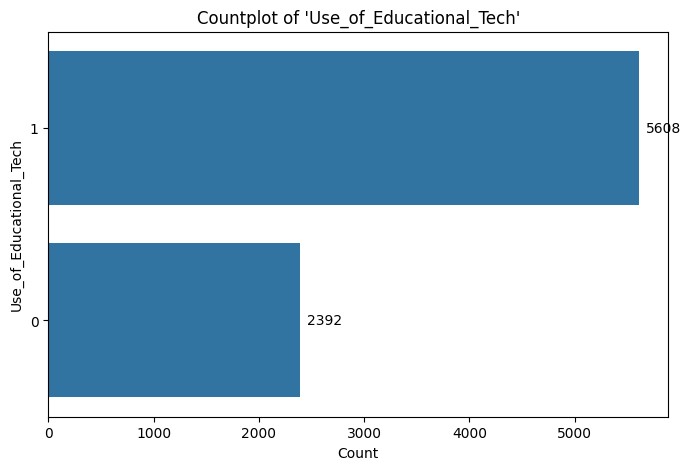

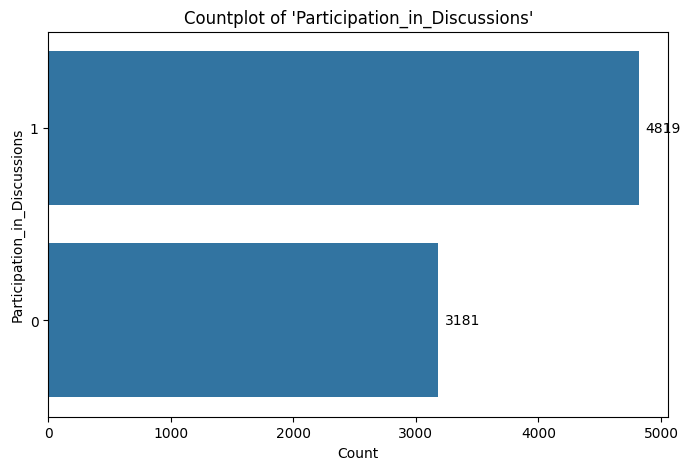

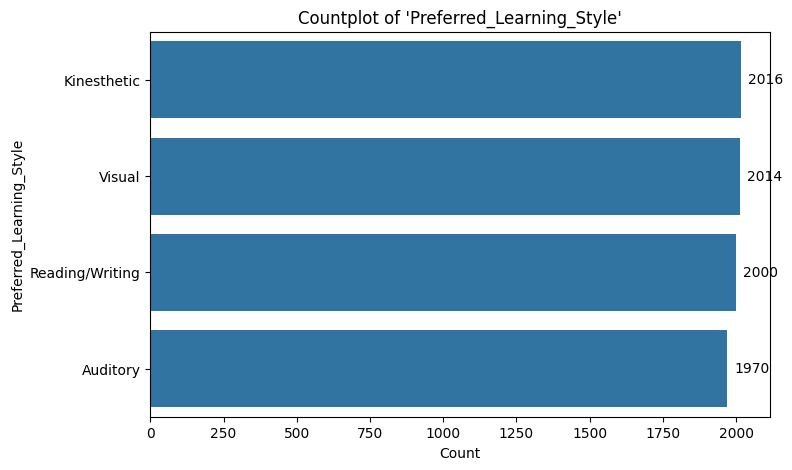

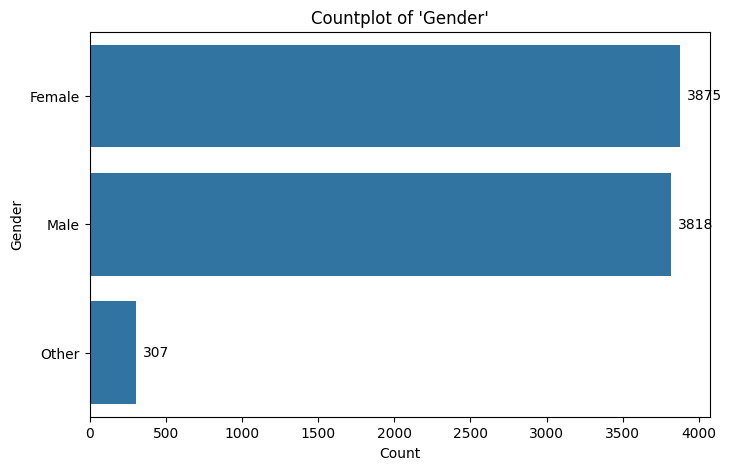

In [118]:
# Define categorical columns
categorical_cols = ["Final_Grade", "Self_Reported_Stress_Level", "Use_of_Educational_Tech", "Participation_in_Discussions", "Preferred_Learning_Style", "Gender"]

# Plot countplots for each categorical col
for col in categorical_cols:
  plt.figure(figsize=(8, 5))
  graph = sns.countplot(y=DR[col], order=DR[col].value_counts().index)
  plt.title(f"Countplot of '{col}'")
  plt.xlabel("Count")
  plt.ylabel(col)
  for p in graph.patches:
    width = p.get_width()
    graph.annotate(f'{int(width)}', xy=(width, p.get_y() + p.get_height() / 2),
                  xytext=(5, 0), textcoords='offset points',
                  ha='left', va='center')
  plt.show()

The preferred learning style and final grade features are approximately normally distributed, while the self-reported stress levels, use of educational technology, participation in discussions, and gender features show a skew toward specific categories. However, there are no significant outliers, with each category representing at least 10% of the data, except for the 'Other' category under Gender, which accounts for 3% of the data. However, this aligns with expectations, as the majority of individuals are likely to identify as either Female or Male, with a smaller proportion identifying as something else. As a result, their are no outliers for the categorical features within this dataset that need to be removed.

**Handling Outliers**

**Numerical**

In this section, the Local Outlier Factor (LOF) method is applied to remove outliers in the Assignment_Completion_Rate and Attendance_Rate columns, which were previously introduced. Since these columns were originally uniformly distributed and not skewed, applying LOF to their logged values is unnecessary. Additionally, both columns are expressed as percentages, meaning they share the same units and do not require scaling, as they will contribute equally when calculating distances in LOF.

Given that the data is densely clustered between 40% and 100% for both columns, a higher n_neighbors value of 50 is used—compared to the n_neighbors of 30 applied in the linear regression analysis. This adjustment accounts for the higher density of data points, which could otherwise lead to minor fluctuations affecting the outlier detection process. By increasing the neighbor sample size, we mitigate unnecessary variation and improve the robustness of LOF.

To handle the detected outliers, we remove the flagged rows rather than treating them as missing values. This ensures that extreme or erroneous values do not distort model fitting, preserving the dataset’s typical relationships. Removing these points helps reduce the risk of overfitting to noise or compromising the model’s validity, as these values are considered genuinely unrepresentative rather than incomplete entries that could be reliably imputed.

In [119]:
def remove_outliers(d_in):
    """
    - Makes a copy of the input DataFrame.
    - Uses LocalOutlierFactor (n_neighbors=50) to detect numeric outliers.
    - Plots outliers vs. inliers in log space for visualization.
    - Keeps only inliers (predictions == 1).
    - Returns the final cleaned dataframe.
    """
    df_lof = d_in.copy()

    # Prepare LOF class, fit, and predict
    lof = LocalOutlierFactor(n_neighbors=50, contamination=0.02)
    predictions = lof.fit_predict(df_lof[["Assignment_Completion_Rate (%)", "Attendance_Rate (%)"]]) 

    # Count & display numeric outliers
    outliers = df_lof[predictions == -1]
    n_outliers = len(outliers)
    print(f"Number of outliers detected (bivariate, log+scaled, auto contamination): {n_outliers}")
    if n_outliers > 0:
        print("Sample outliers:")
        display(outliers.head(5))
    else:
        print("No outliers flagged with these LOF settings.")

    # Results
    plt.figure(figsize=(8, 5))
    # For interpretability, we plot the log-transformed values
    inliers_logged = df_lof[predictions == 1]
    outliers_logged = df_lof[predictions == -1]
    plt.scatter(inliers_logged["Assignment_Completion_Rate (%)"], inliers_logged["Attendance_Rate (%)"],
                label="Inliers", alpha=0.5)
    plt.scatter(outliers_logged["Assignment_Completion_Rate (%)"], outliers_logged["Attendance_Rate (%)"],
                color="red", label="Outliers", marker="x", s=80)
    plt.title("LOF Outliers")
    plt.xlabel("Assignment_Completion_Rate (%)")
    plt.ylabel("Attendance_Rate (%)")
    plt.legend()
    plt.show()

    print("Removing numerical outliers")
    print()
    print(f"Shape before removing numerical outliers: {df_lof.shape}")
    print()
    df_lof = df_lof[predictions == 1].copy()
    print(f"Shape after removing numerical outliers: {df_lof.shape}")
    print()

    return df_lof

### **Section D: Decision Tree Classification**

The Decision Tree Classifier in scikit-learn builds a tree-like model by splitting the data based on feature values to minimize impurity (e.g., Gini index or entropy) at each node. It recursively divides the data into subsets, choosing the best feature to split on at each step. The tree continues to grow until a stopping condition is met, such as maximum depth or minimum sample split, and is then used to classify new data based on the majority class in the leaf nodes.

The Decision Tree classifier in scikit-learn provides 13 hyperparameters, including criterion, splitter, max_depth, min_samples_split, min_samples_leaf, min_weight_fraction_leaf, max_features, random_state, max_leaf_nodes, min_impurity_decrease, class_weight, ccp_alpha, and monotonic_cst. Fine-tuning these parameters for the specific task of predicting the final grade is beyond the scope of this report. Therefore, the default values will be used throughout the analysis to evaluate the model's performance across different dataset configurations.

### **Section E: Feature Engineering**

Two especially useful engineered features that we can create are engagement score and productivity quotient. Engagement score is calculated as the average of Assignment_Completion_Rate and Attendance_Rate. This average provides a more holistic view of academic engagement, as regular class attendance coupled with consistent assignment completion indicates a student's overall commitment and active involvement in their coursework. On the other hand, productivity quotient measures the balance between study time and social media usage by dividing Study_Hours_per_Week by Time_Spent_on_Social_Media (hours/week). This metric can provide insights into a student's ability to prioritize academics over distractions, helping to identify those who maintain a strong focus on their studies.

In [120]:
def add_aggregated_features(df_in):
  """
  Adds two new features:
  - Engagement_Score = (Assignment_Completion_Rate + Attendance_Rate) / 2
  - Productivity_Quotient = Study_Hours_per_Week / Time_Spent_on_Social_Media (hours/week)
  Returns a copy of the dataframe with these new columns.
  """
  df_out = df_in.copy()
  # 1) car_age
  df_out["Engagement_Score"] = (df_out["Assignment_Completion_Rate (%)"] + df_out["Attendance_Rate (%)"]) / 2
  # 2) Study_Efficiency, avoiding division by zero
  df_out["Productivity_Quotient"] = np.where(
    df_out["Time_Spent_on_Social_Media (hours/week)"] == 0,
    1,
    df_out['Study_Hours_per_Week'] / df_out['Time_Spent_on_Social_Media (hours/week)']
  )
  return df_out

### **Section F: Empirical Study**

**Creating the 4 DR variants**

Creating DR1: No outlier removal, no new features.
Created DR1
Creating DR2: No outlier removal, but WITH new features.
Created DR2
Creating DR3: Outlier removal (LOF + categorical), no new features.
Number of outliers detected (bivariate, log+scaled, auto contamination): 159
Sample outliers:


,Gender_Female,Gender_Male,Gender_Other,Preferred_Learning_Style_Auditory,Preferred_Learning_Style_Kinesthetic,Preferred_Learning_Style_Reading/Writing,Preferred_Learning_Style_Visual,Self_Reported_Stress_Level_High,Self_Reported_Stress_Level_Low,Self_Reported_Stress_Level_Medium,Age,Study_Hours_per_Week,Online_Courses_Completed,Participation_in_Discussions,Assignment_Completion_Rate (%),Attendance_Rate (%),Use_of_Educational_Tech,Time_Spent_on_Social_Media (hours/week),Sleep_Hours_per_Night,Final_Grade
6211,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,19,24,17,0,80,17,1,2,10,C
4472,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,28,8,9,1,99,99,0,30,4,A
2807,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,20,14,11,1,52,100,1,7,8,B
7028,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,29,33,19,0,100,73,1,6,5,C
821,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,27,30,16,0,100,51,0,10,8,C


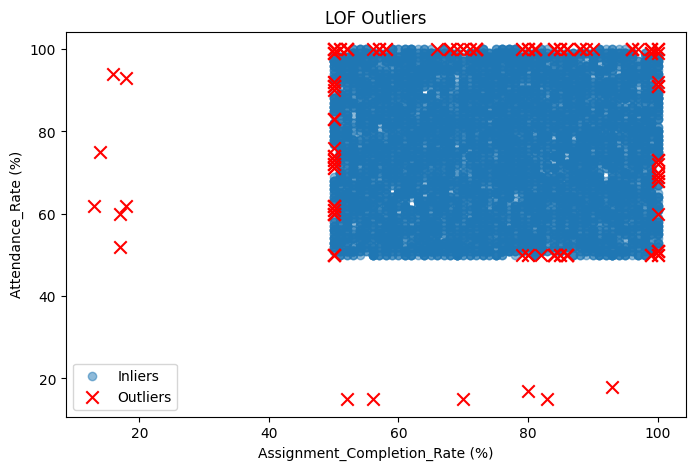

Removing numerical outliers

Shape before removing numerical outliers: (8000, 20)

Shape after removing numerical outliers: (7841, 20)

Created DR3
Creating DR4: Outlier removal + new features.
Number of outliers detected (bivariate, log+scaled, auto contamination): 159
Sample outliers:


,Gender_Female,Gender_Male,Gender_Other,Preferred_Learning_Style_Auditory,Preferred_Learning_Style_Kinesthetic,Preferred_Learning_Style_Reading/Writing,Preferred_Learning_Style_Visual,Self_Reported_Stress_Level_High,Self_Reported_Stress_Level_Low,Self_Reported_Stress_Level_Medium,Age,Study_Hours_per_Week,Online_Courses_Completed,Participation_in_Discussions,Assignment_Completion_Rate (%),Attendance_Rate (%),Use_of_Educational_Tech,Time_Spent_on_Social_Media (hours/week),Sleep_Hours_per_Night,Final_Grade
6211,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,19,24,17,0,80,17,1,2,10,C
4472,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,28,8,9,1,99,99,0,30,4,A
2807,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,20,14,11,1,52,100,1,7,8,B
7028,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,29,33,19,0,100,73,1,6,5,C
821,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,27,30,16,0,100,51,0,10,8,C


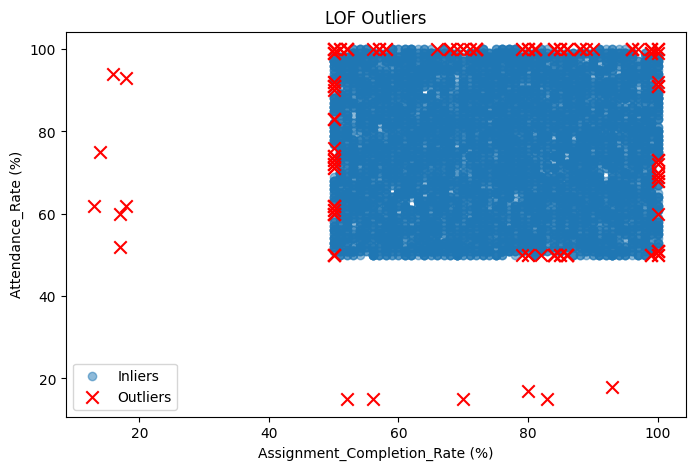

Removing numerical outliers

Shape before removing numerical outliers: (8000, 20)

Shape after removing numerical outliers: (7841, 20)

Created DR4
Shapes after dropping columns:
DR1 shape: (8000, 20)
DR2 shape: (8000, 22)
DR3 shape: (7841, 20)
DR4 shape: (7841, 22)
DT shape: (2000, 20)


In [121]:
# Define columns that we're dropping from DR and DT
# These are the columns that are extra from one-hot encoding
cols_to_drop = ["Gender", "Preferred_Learning_Style", "Self_Reported_Stress_Level"]

print("Creating DR1: No outlier removal, no new features.")
DR1 = DR.copy()
DR1.drop(columns=cols_to_drop, inplace=True, errors="ignore")
print("Created DR1")
print("="*50)

print("Creating DR2: No outlier removal, but WITH new features.")
DR2 = DR.copy()
DR2.drop(columns=cols_to_drop, inplace=True, errors="ignore")
DR2 = add_aggregated_features(DR2)
print("Created DR2")
print("="*50)

print("Creating DR3: Outlier removal (LOF + categorical), no new features.")
DR3 = DR.copy()
DR3.drop(columns=cols_to_drop, inplace=True, errors="ignore")
DR3 = remove_outliers(DR3)
print("Created DR3")
print("="*50)

print("Creating DR4: Outlier removal + new features.")
DR4 = DR.copy()
DR4.drop(columns=cols_to_drop, inplace=True, errors="ignore")
DR4 = remove_outliers(DR4)
DR4 = add_aggregated_features(DR4)
print("Created DR4")
print("="*50)

# Also drop these columns from DT for consistency
DT.drop(columns=cols_to_drop, inplace=True, errors="ignore")

print("Shapes after dropping columns:")
print("DR1 shape:", DR1.shape)
print("DR2 shape:", DR2.shape)
print("DR3 shape:", DR3.shape)
print("DR4 shape:", DR4.shape)
print("DT shape:", DT.shape)


**Running 4-Fold Cross Validation**

In [122]:
def cross_validate_variant(df_variant, cv_splits=4):
  """
  - Splits df_variant into X (features) and y (target)
  - Runs 4-fold cross validation
  - Returns average accuracy, precision, and recall
  """
  kfold = KFold(n_splits=cv_splits)

  # Separate features and target
  X = df_variant.drop(columns=["Final_Grade"])
  y = df_variant["Final_Grade"]
  
  # Setup up the decision tree model
  model = DecisionTreeClassifier()
  
  cross_val_accuracy = []
  cross_val_precision = []
  cross_val_recall = []

  for train_index, test_index in kfold.split(X):
    X_train_split, X_valid_split = X.iloc[train_index], X.iloc[test_index]
    y_train_split, y_valid_split = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train_split, y_train_split)
    y_test_pred = model.predict(X_valid_split)

    cross_val_accuracy.append(accuracy_score(y_test_pred, y_valid_split))
    cross_val_precision.append(precision_score(y_test_pred, y_valid_split, average='macro'))
    cross_val_recall.append(recall_score(y_test_pred, y_valid_split, average='macro'))

  return np.mean(cross_val_accuracy), np.mean(cross_val_precision), np.mean(cross_val_recall)

# Evaluate each variant
variants = [
  ("DR1 (Baseline)", DR1),
  ("DR2 (Features)", DR2),
  ("DR3 (Outliers Removed)", DR3),
  ("DR4 (Outliers Removed+Features)", DR4)
]
results_dict = {}
for name, dfv in variants:
  accuracy, precision, recall = cross_validate_variant(dfv, cv_splits=4)
  results_dict[name] = {"Mean Accuracy": accuracy, "Mean Precision": precision, "Mean Recall": recall}

**Choosing The Best System**

In [123]:
# Convert results dict into a dataframe for clear comparison
results_df = pd.DataFrame.from_dict(results_dict, orient='index')

# Sort table by Mean Accuracy
results_df_sorted = results_df.sort_values(by="Mean Accuracy", ascending=False)
display(results_df_sorted.round(3))

,Mean Accuracy,Mean Precision,Mean Recall
DR3 (Outliers Removed),0.258,0.258,0.259
DR2 (Features),0.252,0.252,0.252
DR1 (Baseline),0.246,0.246,0.245
DR4 (Outliers Removed+Features),0.241,0.241,0.240


The results now show that DR3 (Outliers Removed) has the highest mean accuracy, precession and recall out of the 4 dataset variants. This suggests that removing outliers without the additional features offers a slight improvement. As a result, DR3 will be used within the following final evaluation.

**Testing on DT**

In [124]:
# Prepare DR4 for final training
X_train = DR3.drop(columns=["Final_Grade"])
y_train = DR3["Final_Grade"]

# Train a final linear regression model on DR
final_model = DecisionTreeClassifier()
final_model.fit(X_train, y_train)

# Prepare the test set the same way we prepared DR (minus outlier removal)
DT.drop(columns=cols_to_drop, inplace=True, errors="ignore")

# Split the test set into features and target 
X_test = DT.drop(columns=["Final_Grade"])
y_test = DT["Final_Grade"]

# Predict on the test set
y_pred = final_model.predict(X_test)

# Calculate test set metrics
test_accuracy  = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred, average='macro')
test_recall = recall_score(y_test, y_pred, average='macro')
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test precision:  {test_precision:.4f}")
print(f"Test recall:  {test_recall:.4f}")

Test accuracy: 0.2690
Test precision:  0.2686
Test recall:  0.2686


### **Section G: Results Analysis**

**a) Analysis of Obtained Results and Improvement**

The experiments with different model configurations on the validation set revealed minimal performance improvements. Removing outliers using LOF (DR3) provided a marginal gain over the baseline (DR1), increasing accuracy from 0.249 to 0.250, which suggests that outlier removal slightly reduced noise. However, feature engineering alone (DR2) degraded performance (0.245 accuracy), indicating that the added features introduced redundancy or noise rather than meaningful signal. Combining outlier removal with feature engineering (DR4) further underperformed DR3, demonstrating no synergistic benefit. All models exhibited consistently low validation metrics (~24-25% accuracy, precision, recall), highlighting poor separability in the data or an inability of the decision tree to capture robust patterns. Overall, no configuration achieved meaningful improvement, underscoring limitations in the data’s informativeness or the model’s capacity to generalize.

**b) Impact of Outlier Detection and Feature Aggregation**

Removing outliers from the dataset improved model performance across all metrics; however, adding the engineered features appeared to decrease accuracy. The worst-performing datasets were DR4 (Outliers Removed + Features) and DR2 (Features), with DR2 achieving the lowest scores across all metrics.

The introduced features—Engagement Score and Productivity Quotient—were designed to capture academic commitment and study habits. While theoretically valuable, they may have negatively impacted performance for several reasons. First, these features aggregate multiple variables, potentially smoothing out important distinctions between students. Second, they assume linear relationships between engagement, productivity, and academic success, which may not hold universally. Lastly, if the original dataset already contained strong predictive signals, these derived metrics could introduce redundancy or amplify noise, leading to degraded model performance.

Overall, removing outliers proved beneficial, as seen in DR3's superior performance and DR4's improved performance over DR2. However, feature engineering introduced noise, making it harder for the model to learn meaningful relationships.

**c) Comparing Test-Set Results to Cross-Validation Results**

Test set performance (0.264 accuracy, precision, and recall) showed a slight increase compared to cross-validation results (~24.9-25.0%), which is atypical, as test metrics usually match or fall below validation due to overfitting. This minor discrepancy could stem from random variability in small metric differences (e.g., 0.25 vs. 0.26) or a test set with a simpler distribution (e.g., fewer edge cases). However, the persistence of low scores across both validation and test sets (~25-26%) reinforces that the model struggled to learn meaningful patterns, regardless of data partitioning. The trivial test-set gains do not indicate robust generalization but rather emphasize systemic challenges in the data or model design, such as weak feature relevance or insufficient complexity in the decision tree.

### **Conclusion**


Throughout this notebook, we cleaned, explored, and transformed a dataset focused on student performance and learning styles, examining the effects of outlier removal and feature engineering on a decision tree model. Data validation ensured that the dataset's columns conformed to the expected types, ranges, and values, with exact duplicates removed to avoid redundancy. Categorical features were one-hot encoded to ensure compatibility with the scikit-learn decision tree classifier, while the Local Outlier Factor (LOF) method was applied to detect extreme numeric outliers. New features were introduced to capture engagement and productivity metrics, although these ultimately resulted in a decrease in model performance.

Multiple dataset variants were created and evaluated using the default settings of the decision tree model in scikit-learn. The approach that focused solely on outlier removal demonstrated stronger performance during cross-validation, achieving higher accuracy, precision, and recall compared to simpler alternatives. The final evaluation on unseen data showed a slight increase in model accuracy, suggesting that certain patterns learned during training were successfully generalized to new data, though the overall accuracy remained modest.

### **References**

[1] https://www.kaggle.com/datasets/adilshamim8/student-performance-and-learning-style